# **Model engineering - Part: Transfer Learning**

## **Research question**
Can transfer learning bring a benefit on the performance of CNN models for Rock, Paper, Scissors?

**Reference:** </br>
Code according to: [learnpytorch.io](https://www.learnpytorch.io/05_pytorch_going_modular/)

### Imports

In [30]:
import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from timeit import default_timer as timer 
from pathlib import Path
from loguru import logger
import pickle
from datetime import datetime
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from typing import List, Tuple
from PIL import Image
import random
import time
import math

### Function to create the DataLoader

In [3]:
def create_dataloaders(train_dir: str, 
                            test_dir: str, 
                            transform: transforms.Compose, 
                            batch_size: int, 
                            num_workers: int=1
                        ):
    
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
   
    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(train_data,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=num_workers,
                                    pin_memory=True
                                )
    test_dataloader = DataLoader(test_data,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=num_workers,
                                    pin_memory=True
                                )

    return train_dataloader, test_dataloader, class_names


### Function to load the pretrained model

In [4]:
def load_pretrained_efficientNet_B0():

    # Load best available weights from pretraining on ImageNet
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    
    # Load pretrained model with selected weights
    model = torchvision.models.efficientnet_b0(weights=weights)

    return model, weights

### Function to load the dataset

In [5]:
def load_data(train_dir: str, test_dir: str, weights, num_workers: int, batch_size: int):
    # Get the transforms used to create our pretrained weights
    auto_transforms = weights.transforms()

    # Create training and testing DataLoaders as well as get a list of class names
    train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                                batch_size=batch_size, # set mini-batch size to 32
                                                                                num_workers=num_workers) 


    return train_dataloader, test_dataloader, class_names

### Function to recreate the classifier layer of the model

In [6]:
def recreate_classifier_layer(model: torch.nn.Module, dropout: int, class_names: list):
    # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
    for param in model.features.parameters():
        param.requires_grad = False

    # Set the manual seeds
    torch.manual_seed(42)

    # Recreate the classifier layer
    model.classifier = torch.nn.Sequential(
                            torch.nn.Dropout(p=dropout, inplace=True), 
                            torch.nn.Linear(in_features=1280, 
                            out_features=len(class_names), # one output unit for each class
                            bias=True))

    return model

### Functions to train the pretrained model

In [7]:
def train_step(model: torch.nn.Module, 
                    dataloader: torch.utils.data.DataLoader, 
                    loss_fn: torch.nn.Module, 
                    optimizer: torch.optim.Optimizer
                ) -> Tuple[float, float]:

  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [8]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module
              ) -> Tuple[float, float]:

  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [9]:
def train(model: torch.nn.Module, 
            train_dataloader: torch.utils.data.DataLoader, 
            test_dataloader: torch.utils.data.DataLoader, 
            optimizer: torch.optim.Optimizer,
            loss_fn: torch.nn.Module,
            epochs: int,
            folderpath: str
            ) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": []
            }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer
                                            )
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn
            )

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


    model_folder = store_model(folderpath, model, results)

    # Return the filled results at the end of the epochs
    return results, model_folder

### Function to save the new model

In [10]:
def store_model(folderpath: Path, classifier_model:torch.nn.Module, results:dict):
    logger.info("Store model...")
    model_path = folderpath / ("model.pkl")
    results_path = folderpath / ("results.pkl")

    with open(model_path, "wb") as filestore:
        pickle.dump(classifier_model, filestore)

    with open(results_path, "wb") as filestore:
        pickle.dump(results, filestore)

    logger.info("Model stored!")

    return folderpath

### Function to create a folder for the new model

In [11]:
def get_storage_name(targetfolder:str, model_name:str):
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d%m%Y_%H%M")
    folderpath = Path(targetfolder + "/" + model_name + "_model" + "_" + timestampStr)
    folderpath.mkdir(parents=True, exist_ok=True)

    return folderpath

### Function to store the hyperparameters

In [12]:
def store_hyperparameters(target_dir_new_model:str,model_name:str, dict:dict):
    folderpath = get_storage_name(target_dir_new_model, model_name)
    
    dict_path = folderpath / ("hyperparameter_dict.pkl")
    with open(dict_path, "wb") as filestore:
        pickle.dump(dict, filestore)
    return folderpath

### Function to load the model

In [13]:
def get_model(model_folder: str):
    onlyfiles = [f for f in listdir(model_folder) if isfile(join(model_folder, f))]

    model_path = model_folder / onlyfiles[1]
    results_path = model_folder / onlyfiles[2]
    hyperparameters_path = model_folder / onlyfiles[0]

    with open(model_path, "rb") as fid:
        classifier_model = pickle.load(fid)

    with open(results_path, "rb") as fid:
        results = pickle.load(fid)

    with open(hyperparameters_path, "rb") as fid:
        dict = pickle.load(fid)

    logger.info("Model and hyperparameters loaded!")

    return classifier_model, results, dict

### Function for plotting the loss curve and the accuracy

In [14]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.
    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

### Function to make predictions on validation images

In [110]:
def pred_and_plot_image(model: torch.nn.Module,
                            image_path: str,
                            class_names: List[str] = None,
                            transform=None,
                            ax=None):

    # Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image)

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    if ax is None:
        # Plot the image alongside the prediction and prediction probability
        plt.imshow(
            target_image.squeeze().permute(1, 2, 0)
        )  # make sure it's the right size for matplotlib
        if class_names:
            title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        else:
            title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        plt.title(title)
        plt.axis(False)
    else:
        plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.45,
                            top=0.5,
                            wspace=0.4,
                            hspace=0.4)
        # Plot the image alongside the prediction and prediction probability
        ax.imshow(
            target_image.squeeze().permute(1, 2, 0)
        )  # make sure it's the right size for matplotlib
        if class_names:
            title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        else:
            title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        ax.set_title(title)
        ax.axis(False)


In [99]:
def train_new_TransferLearning_model(dataset_path:str, seed:int, learning_rate:float, epochs:int, dropout:float, num_workers:int, batch_size:int):
    train_dir = dataset_path + "/train"
    test_dir = dataset_path + "/test"
    target_dir_new_model = '../models'
    model_name = "TransferLearning"

    dict_hyperparameters = {'seed': seed, 'learning_rate':learning_rate, 'epochs': epochs, 
                        'dropout':dropout, 'num_workers':num_workers,'batch_size': batch_size}

    folderpath = store_hyperparameters(target_dir_new_model,model_name=model_name,dict=dict_hyperparameters)

    # Load pretrained model, weights and the transforms
    model, weights = load_pretrained_efficientNet_B0()

    # Load data
    train_dataloader, test_dataloader, class_names = load_data(train_dir=train_dir,
                                                                    test_dir=test_dir, 
                                                                    weights=weights, 
                                                                    num_workers=num_workers, 
                                                                    batch_size=batch_size)

    # Recreate classifier layer
    model = recreate_classifier_layer(model=model, 
                                            dropout=dropout, 
                                            class_names=class_names)

    # Define loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set the random seeds
    torch.manual_seed(seed)

    # Start the timer
    start_time = timer()

    # Setup training and save the results
    results, model_folder = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=epochs,
                        folderpath=folderpath
                    )



    # End the timer and print out how long it took
    end_time = timer()

    time.sleep(10)
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
    plot_loss_curves(results)
    
    return model_folder

In [102]:
def eval_existing_model(model_folder:str,validation_folder:str, num_images:int):

    trained_model, model_results, dict_hyperparameters = get_model(Path(model_folder))

    plot_loss_curves(model_results)

    # Make predictions on random images from validation dataset
    val_dir = "../data_combined/dataset_splitted/val"
    class_names = ['paper', 'rock', 'scissors']

    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    auto_transforms = weights.transforms()

    valid_image_path_list = list(Path(validation_folder).glob("*/*.*")) # get list all image paths from test data 
    valid_image_path_sample = random.sample(population=valid_image_path_list, # go through all of the test image paths
                                        k=num_images) # randomly select 'k' image paths to pred and plot

    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
    fig, axes = plt.subplots(math.ceil(num_images/2),2, figsize=(15,15))
    plt.rc('font', **font)

    # Make predictions on and plot the images
    for image_path, ax in zip(valid_image_path_sample,axes.ravel()):
        pred_and_plot_image(model=trained_model, 
                            image_path=image_path,
                            class_names=class_names,
                            transform=auto_transforms,
                            ax = ax)
    if num_images%2 != 0:
        fig.delaxes(axes[math.ceil(num_images/2)-1,1])

In [106]:
def pred_on_single_image(image_path:str, model_folder:str):
    class_names = ['paper', 'rock', 'scissors']

    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    auto_transforms = weights.transforms()

    trained_model, model_results, dict_hyperparameters = get_model(Path(model_folder))


    pred_and_plot_image(trained_model, image_path, class_names, auto_transforms)

## Main-method

2022-11-10 12:29:21.052 | INFO     | __main__:get_model:17 - Model and hyperparameters loaded!
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


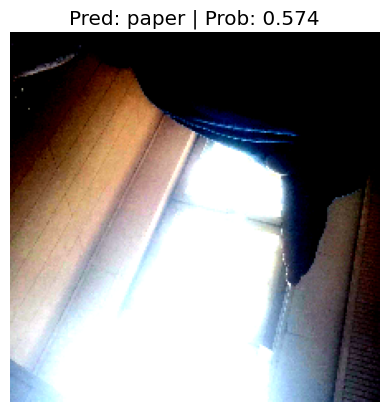

In [117]:
# Define dataset path
dataset_path = '../data_combined/dataset_splitted'
model_folder = "../models/model_08112022_2233"
validation_folder = "../data_combined/dataset_splitted/val"
single_image_path = "../data_own_images/paper_Tobi.jpg"


# Set parameters
seed = 42
learning_rate = 0.001
epochs = 5
dropout = 0.2
num_workers = 2
batch_size = 32
num_images_val = 6

# Set if you want to train a new model or evualate an existing model
train_new_transferlearning_model = False
train_new_baseline_model = False
evaluate_existing_model = False
prediction_on_single_image = True

if train_new_transferlearning_model:
    model_folder = train_new_TransferLearning_model(dataset_path=dataset_path,
                                                        seed=seed, 
                                                        learning_rate=learning_rate,
                                                        epochs=epochs,
                                                        dropout=dropout,
                                                        num_workers=num_workers,
                                                        batch_size=batch_size)  
    eval_existing_model(model_folder=model_folder, validation_folder=validation_folder, num_images=num_images_val)  

if evaluate_existing_model:
    eval_existing_model(model_folder=model_folder, validation_folder=validation_folder, num_images=num_images_val)

if prediction_on_single_image:
    pred_on_single_image(image_path=single_image_path, model_folder=model_folder)
